<a href="https://colab.research.google.com/github/ThomasMcDaniel91/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

The target variable for this project is going to be the User_Score which is a regression problem. The data for this is skewed towards the right side peaking at around 7.9.

The evaluation metric for this model is going to be MAE.

Going to test the model with the most recent year of sales data and do a train/validate test split randomly with the remainder.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving video-game-sales-with-ratings.zip to video-game-sales-with-ratings.zip


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
!pip install category_encoders==2.*
import category_encoders as ce
from sklearn.metrics import accuracy_score

In [137]:
df = pd.read_csv('/content/video-game-sales-with-ratings.zip')
print(df.shape)
df.head()

(16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Replacing the filler for user score with nans.
df['User_Score'] = df['User_Score'].replace({'tbd': np.nan})

In [139]:
#dropping columns with nans in the target column. removed 9129 rows leaving 7590.
df = df.dropna(subset=['User_Score'])
print(df.shape)
df.head()

(7590, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


In [140]:
df['User_Score'] = pd.to_numeric(df['User_Score'])
df['User_Score'].dtype

dtype('float64')

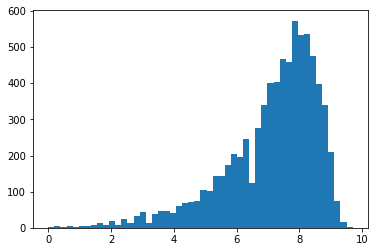

In [141]:
plt.hist(df['User_Score'], bins=50);

In [142]:
df.nunique()

Name               4694
Platform             17
Year_of_Release      25
Genre                12
Publisher           280
NA_Sales            353
EU_Sales            275
JP_Sales            158
Other_Sales         145
Global_Sales        545
Critic_Score         82
Critic_Count        106
User_Score           95
User_Count          888
Developer          1368
Rating                8
dtype: int64

In [143]:
#getting a baseline of using the mean for all values
scores_mean = df['User_Score'].mean()
base_mean = [scores_mean] * len(df['User_Score'])
baseline_model = mean_absolute_error(df['User_Score'], base_mean)
baseline_model = baseline_model
baseline_model
#based on guessing the mean of all the user scores we have an average MAE of 1.15

1.1549783797764461

In [0]:
test = df[df['Year_of_Release'] == 2015]
train = df[df['Year_of_Release'] < 2015]

In [0]:
train, val = train_test_split(train, train_size=0.8)

In [146]:
train.shape, val.shape, test.shape

((5523, 16), (1381, 16), (297, 16))

In [0]:
target = 'User_Score'
#using everything for the features besides the target and the global sales which
#is redundant.
all_feats = train.drop(columns=[target, 'Global_Sales'])
features = all_feats.select_dtypes(include='number').columns.tolist()
features
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    ce.OneHotEncoder(use_cat_names=True),
    LinearRegression()

)

In [167]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [168]:
pipeline.score(X_val, y_val)

0.32845648088210844

In [173]:
y_pred = pipeline.predict(X_test)
test_acc = mean_absolute_error(test[target], y_pred)
test_acc

1.162059302725552